## 1.数据预处理阶段

In [6]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import pandas as pd
fi_id_nfi_dict_path = "./data/fi_nfi_id.pkl"
feature_id_time_spatial_path = "./data/feature_id_time_spatial.pkl"
Best_label_cluster_path = "./processing/Best_label_cluster.pkl"
BDP_val_prediction_path = "./data/BDP_val_prediction.pkl"

fi_id_nfi_dict = np.load(fi_id_nfi_dict_path, allow_pickle=True)
Best_label_cluster  = np.load(Best_label_cluster_path, allow_pickle=True)
feature_id_time_spatial = np.load(feature_id_time_spatial_path, allow_pickle=True)
BDP_val_prediction = np.load(BDP_val_prediction_path, allow_pickle=True)
# print(Best_label_cluster)
# print(BDP_val_prediction)
# print(feature_id_time_spatial)
# print(fi_id_nfi_dict)



FileNotFoundError: [Errno 2] No such file or directory: './data/fi_nfi_id.pkl'

### 1.1统计positive&negative在各个簇的占比

In [5]:
p_n_ratio = {}
pos = []
pos_pro = []
neg = []
neg_pro = []

for id_cluster, fid_list in Best_label_cluster.items():
    labels_n_p = [0]*2
    for f_id in fid_list:
        label = BDP_val_prediction[f_id]['ground truth']
        labels_n_p[label] += 1
    p_n_ratio[id_cluster] = labels_n_p
for id_cluster, l_n_p in p_n_ratio.items():
    a = l_n_p[0]/(l_n_p[0]+l_n_p[1])
    b = l_n_p[1]/(l_n_p[0]+l_n_p[1])
    neg.append(l_n_p[0])
    pos.append(l_n_p[1])
    neg_pro.append(a)
    pos_pro.append(b)    
    print("id_cluster:{} negative:{}/{}, positive:{}/{}".format(id_cluster, l_n_p[0], a, l_n_p[1], b))
id_clusters = list(p_n_ratio.keys())
result = { "Cluster ID": id_clusters, "Number of negative":neg, "Proportion of negative": neg_pro,
          "Number of positive":pos, "Proportion of positive":pos_pro
}
data = pd.DataFrame(result, index=None)
data.to_csv("./pdf/Cluster_info.csv")

id_cluster:4 negative:117/0.3588957055214724, positive:209/0.6411042944785276
id_cluster:1 negative:120/0.5357142857142857, positive:104/0.4642857142857143
id_cluster:0 negative:117/0.5679611650485437, positive:89/0.4320388349514563
id_cluster:2 negative:118/0.5267857142857143, positive:106/0.4732142857142857
id_cluster:3 negative:135/0.574468085106383, positive:100/0.425531914893617


## 2.频谱图的构建

In [9]:

def spectrogram_draw(data):
    duration_time = 2
    x = np.arange(0, duration_time, 0.01)
    plt.plot(x, data)
    plt.xlabel("Time [sec]")
    plt.ylabel("Voltage [v]")
    NFFT = 200
    Fs = 100
    plt.show()
    Pxx, freqs, bins, im = plt.specgram(data, NFFT=NFFT, Fs=Fs, noverlap=0)
    plt.xlabel("Time [sec]")
    plt.ylabel("Frequency [Hz]")
    plt.show()

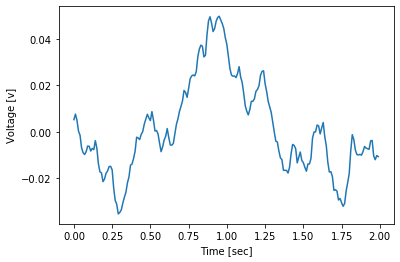

/home/cbd109-3/applications/anaconda3/envs/ching/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Only one segment is calculated since parameter NFFT (=200) >= signal length (=200).
  # Remove the CWD from sys.path while we load stuff.


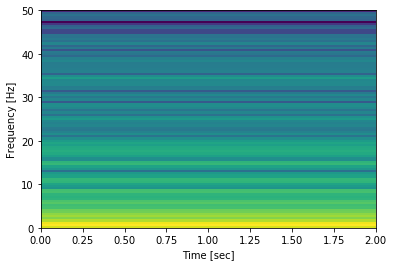

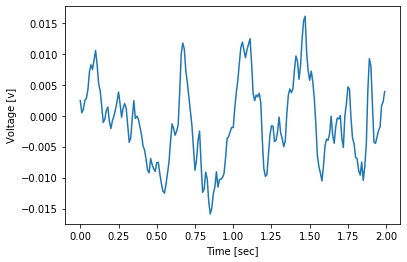

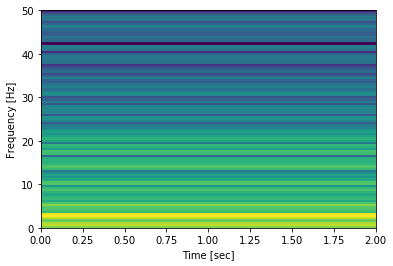

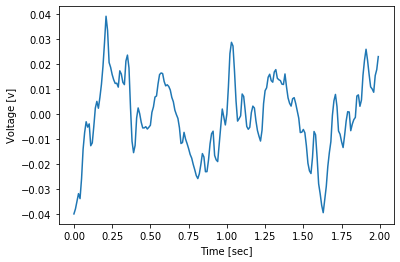

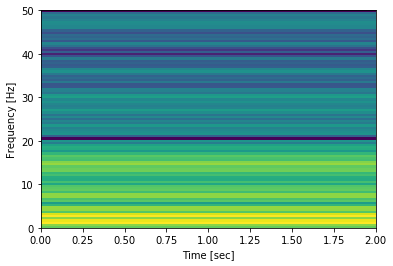

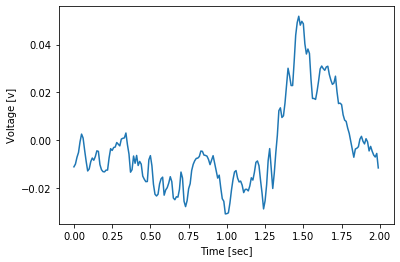

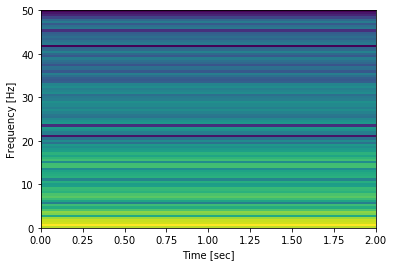

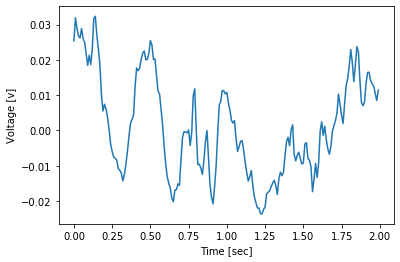

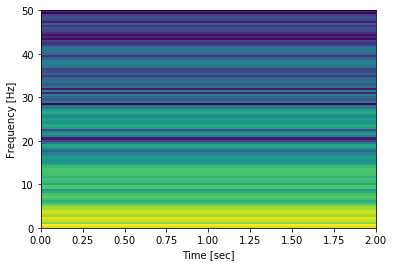

In [10]:
for cluster_id, fi_ids in Best_label_cluster.items():
    data_y = np.zeros(200)
    for fi_id in fi_ids:
        # print(fi_id)
        # raw_data_path = fi_id_nfi_dict
        raw_data_nfi = np.load(fi_id_nfi_dict[fi_id]['nfi_path'], allow_pickle=True)
        channel_spot = feature_id_time_spatial[fi_id]["spatial"]
        channel_data = raw_data_nfi[channel_spot]
        data_y += channel_data
    # print(data_y)
    spectrogram_draw(data_y)
    
    
    
    



## 3.相似度较高的数据展示

In [11]:
from dtw import dtw
from tqdm.notebook import tqdm as tqdm

def similarity_DTW(s1, s2):
    ratio = 50 # 设定的放缩系数，避免数据的相似度过于集中
    euclidean_norm = lambda x, y: np.abs(ratio * (x - y))
    d, cost_matrix, acc_cost_matrix, path = dtw(s1, s2, dist=euclidean_norm)
    score = 1 - np.tanh(d)  # 相似度的评分【0,1】 0： 完全不同， 1： 完全相同
    return score

def get_top_score_series(series_dict, dba_wave, top_n = 3):
    top_wave_cluster = {}
    for cluster_id, feature_data in tqdm(series_dict.items()):
        dba_w = dba_wave[cluster_id]
        cluster_score ={}
        for _d, _id in tqdm(feature_data):
            score = similarity_DTW(_d, dba_w)
            cluster_score[_id] = score
        cluster_result = sorted(cluster_score.items(), key=lambda x:-x[1])
        top_wave_cluster[cluster_id] = cluster_result[:top_n]
    return top_wave_cluster

# 选择符合特定要求的feature,比如是关于疾病的feature.
def get_top_score_series_positive(series_dict, dba_wave, top_n = 10, positive= True):
    top_wave_cluster_selected = {}
    for cluster_id, feature_data in tqdm(series_dict.items()):
        dba_w = dba_wave[cluster_id]
        cluster_score ={}
        for _d, _id in tqdm(feature_data):
            score = similarity_DTW(_d, dba_w)
            cluster_score[_id] = score
        cluster_result = sorted(cluster_score.items(), key=lambda x:-x[1])
        cluster_result_positive = []
        count = 0
        index = 0
        flag = 1 if positive else 0
        while count < top_n and count < len(feature_data):
            f_id_score = cluster_result[index]
            ground_t = BDP_val_prediction[f_id_score[0]]["ground truth"]
            
            if ground_t == flag:
                cluster_result_positive.append(f_id_score)
                count += 1
            index += 1
        top_wave_cluster_selected[cluster_id] = cluster_result_positive
    return top_wave_cluster_selected
    
    
    

In [12]:
wave_clusters_id_feature_data_path = "./processing/wave_clusters_id_feature_data.pkl"
DBA_wave_path = "./processing/DBA_wave.pkl"
wave_clusters_id_feature_data = np.load(wave_clusters_id_feature_data_path, allow_pickle=True)
DBA_wave = np.load(DBA_wave_path, allow_pickle=True)
top_wave_cluster = get_top_score_series_positive(wave_clusters_id_feature_data, DBA_wave, top_n=10, positive=True)

In [13]:
# print(top_wave_cluster)

{2: [('b12e66d2-2555-11ea-9699-e0d55e6ff654-0.npy', 0.8519320152646708), ('b1547100-2555-11ea-9699-e0d55e6ff654-0.npy', 0.8443467802126056), ('e076f404-2552-11ea-9699-e0d55e6ff654-0.npy', 0.8440448827024094), ('b12e687d-2555-11ea-9699-e0d55e6ff654-0.npy', 0.8414258912042433), ('b15470ae-2555-11ea-9699-e0d55e6ff654-0.npy', 0.8413590760488734), ('b1546f87-2555-11ea-9699-e0d55e6ff654-0.npy', 0.8411221614724311), ('b1547097-2555-11ea-9699-e0d55e6ff654-0.npy', 0.837292719210443), ('b15470a7-2555-11ea-9699-e0d55e6ff654-0.npy', 0.836178395808439), ('b12e6900-2555-11ea-9699-e0d55e6ff654-0.npy', 0.8355445464013368), ('b12e669b-2555-11ea-9699-e0d55e6ff654-0.npy', 0.8334952135629293)], 3: [('b12e684a-2555-11ea-9699-e0d55e6ff654-0.npy', 0.9605567894522832), ('b12e666a-2555-11ea-9699-e0d55e6ff654-0.npy', 0.9547789033410146), ('b12e66ba-2555-11ea-9699-e0d55e6ff654-0.npy', 0.9540476260923931), ('b12e6689-2555-11ea-9699-e0d55e6ff654-0.npy', 0.9528388177512921), ('b12e67e4-2555-11ea-9699-e0d55e6ff654-0

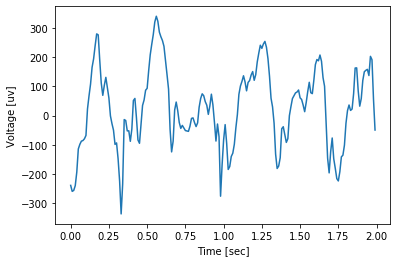

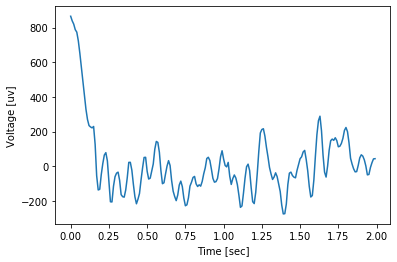

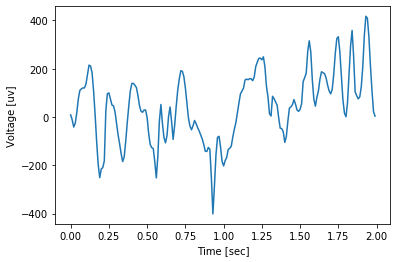

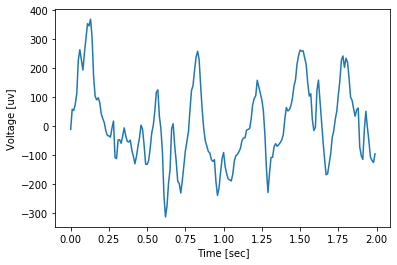

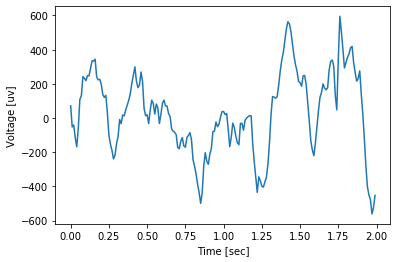

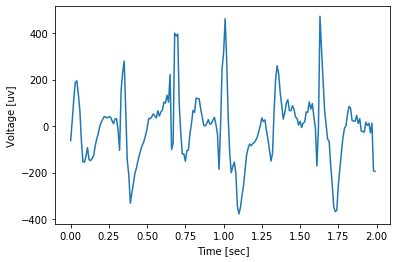

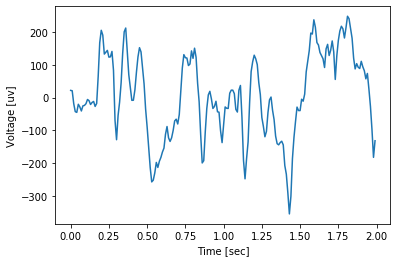

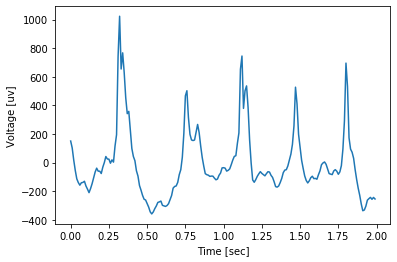

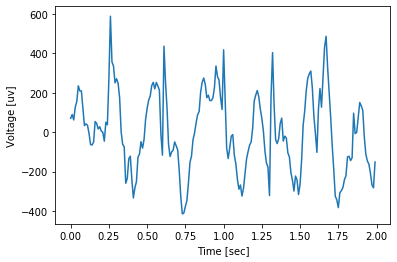

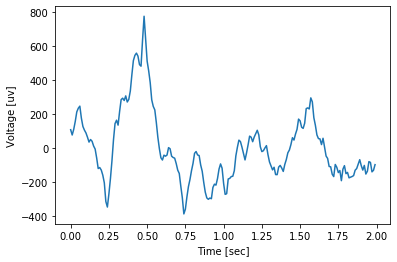

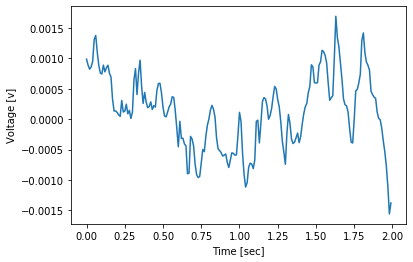

/home/cbd109-3/applications/anaconda3/envs/ching/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Only one segment is calculated since parameter NFFT (=200) >= signal length (=200).
  # Remove the CWD from sys.path while we load stuff.
/home/cbd109-3/applications/anaconda3/envs/ching/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Only one segment is calculated since parameter NFFT (=200) >= signal length (=200).
  # Remove the CWD from sys.path while we load stuff.
/home/cbd109-3/applications/anaconda3/envs/ching/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Only one segment is calculated since parameter NFFT (=200) >= signal length (=200).
  # Remove the CWD from sys.path while we load stuff.
/home/cbd109-3/applications/anaconda3/envs/ching/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Only one segment is calculated since parameter NFFT (=200) >= signal length (=200).
  # Remove the CWD from sys.path while

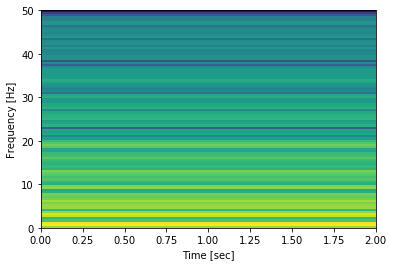

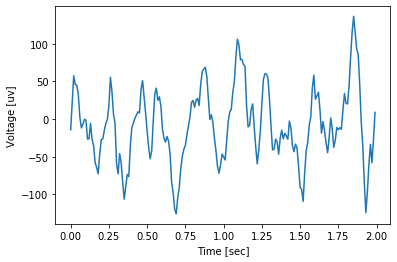

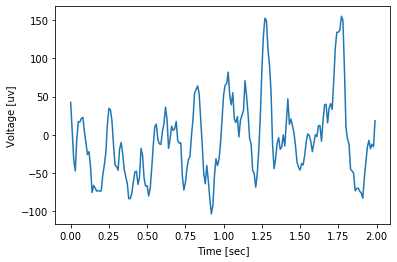

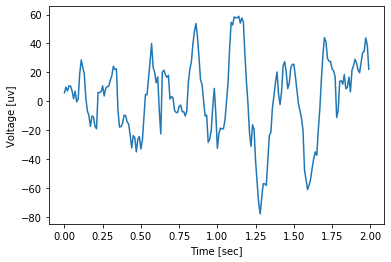

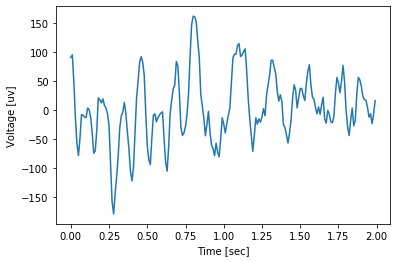

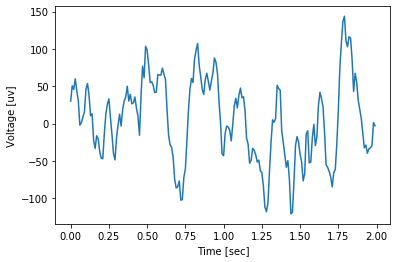

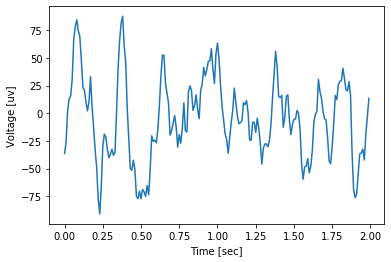

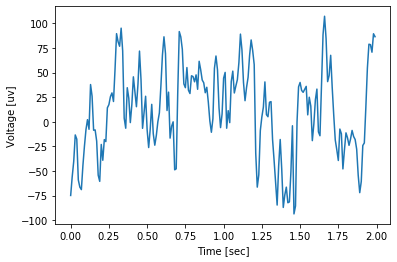

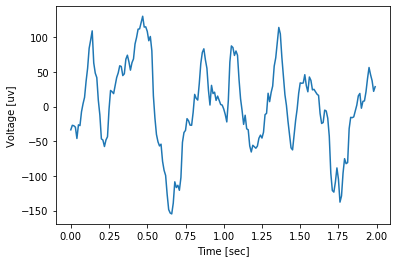

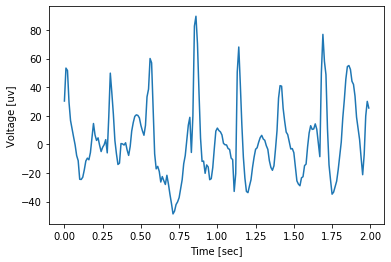

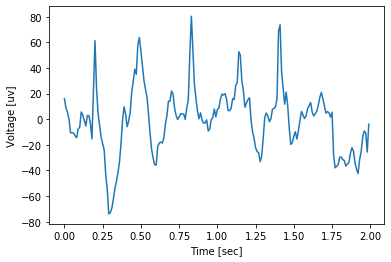

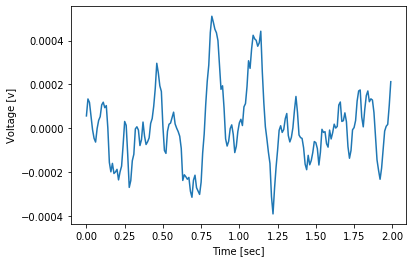

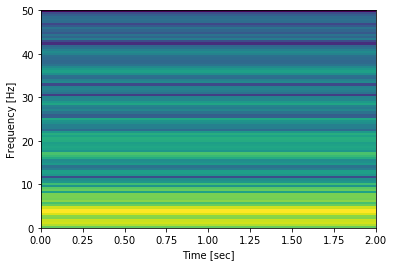

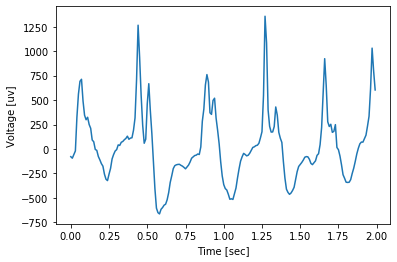

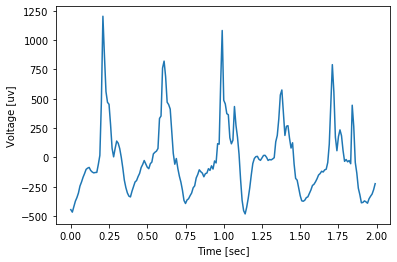

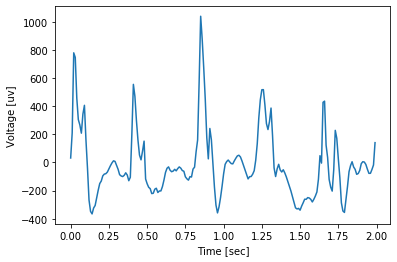

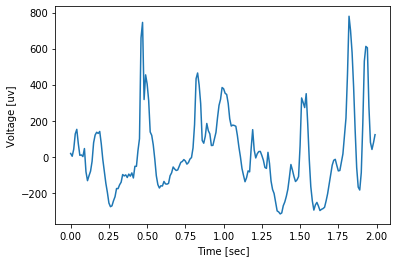

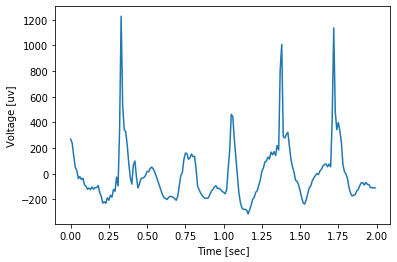

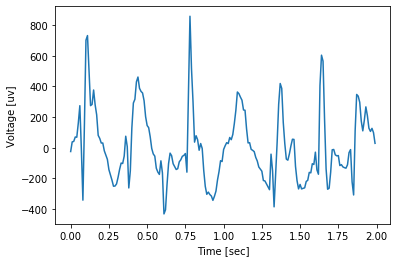

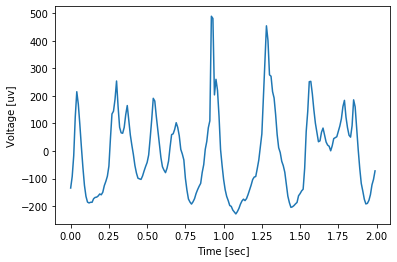

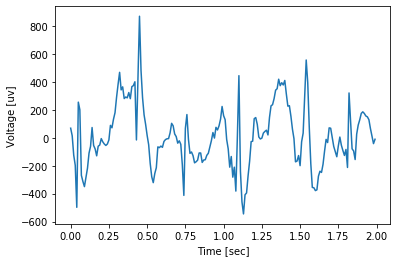

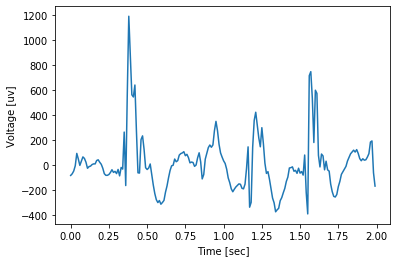

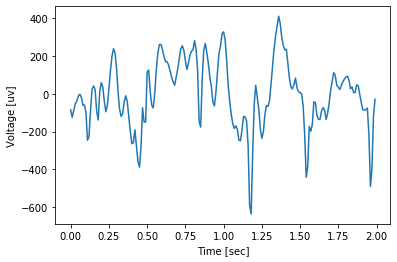

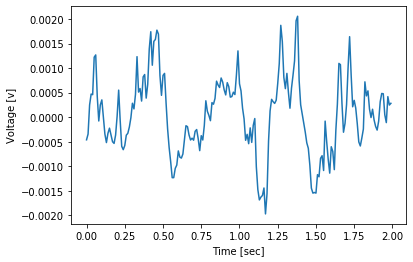

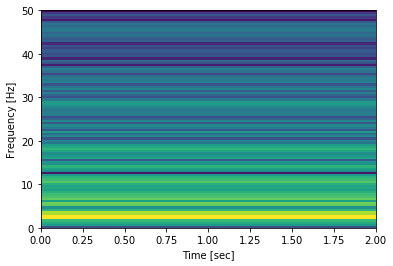

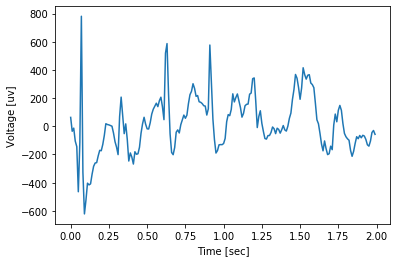

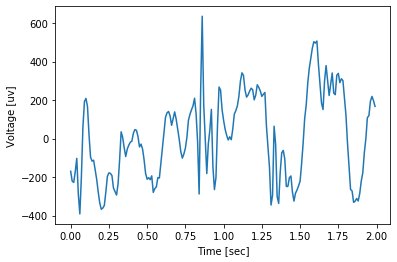

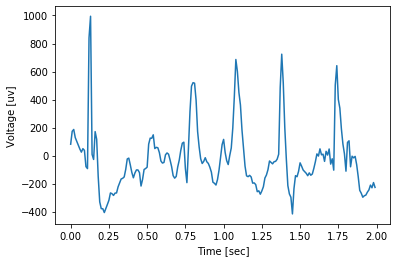

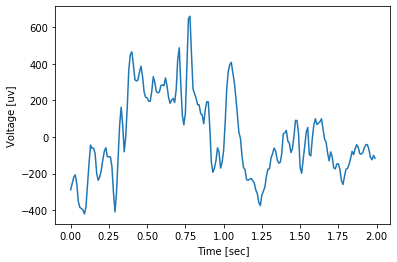

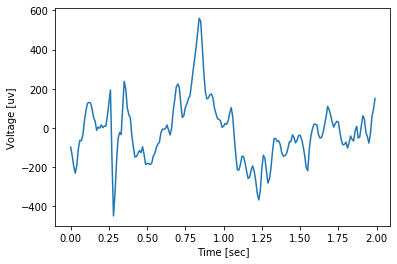

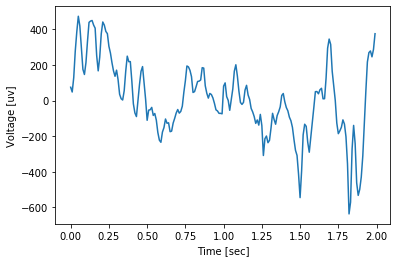

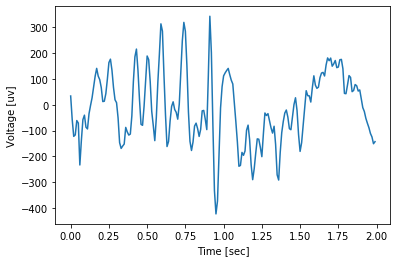

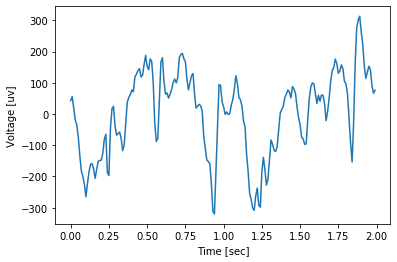

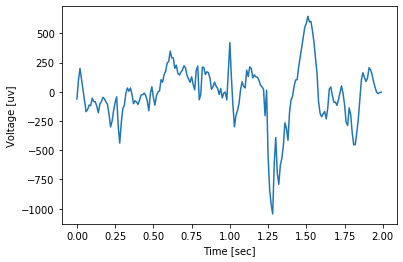

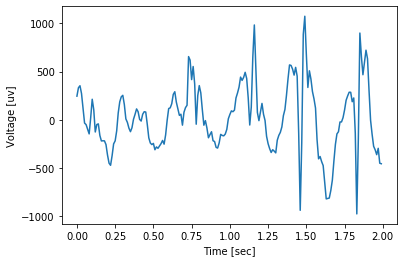

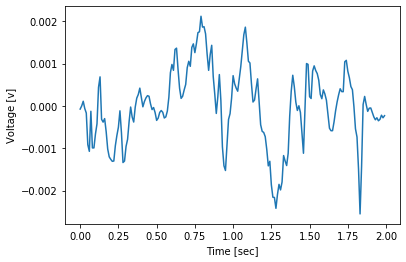

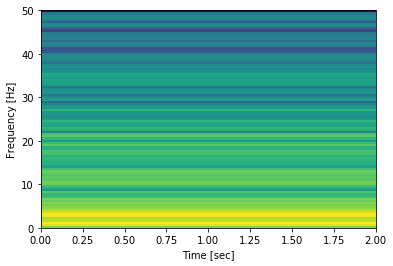

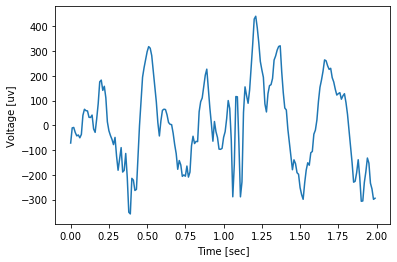

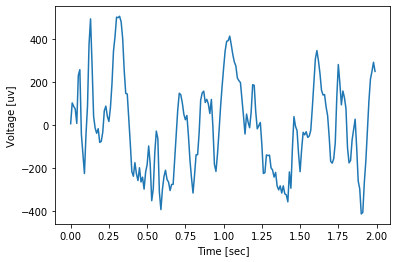

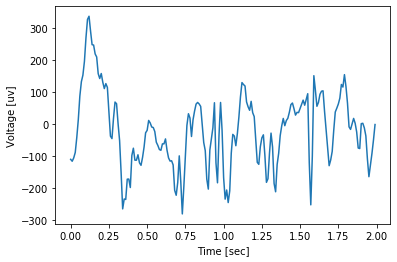

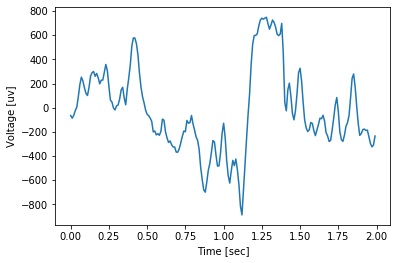

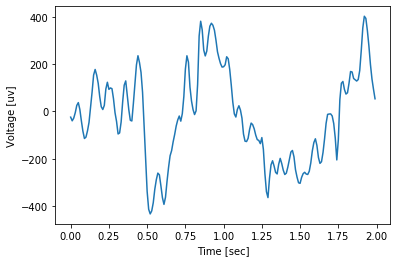

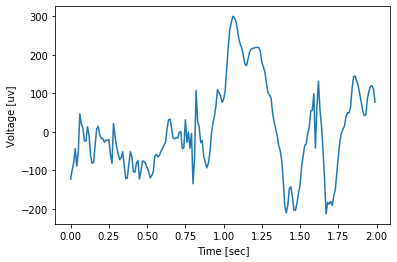

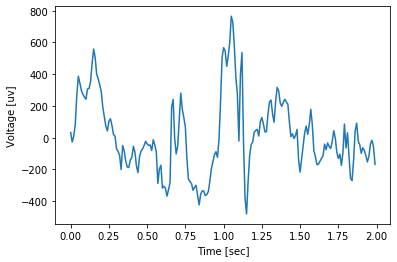

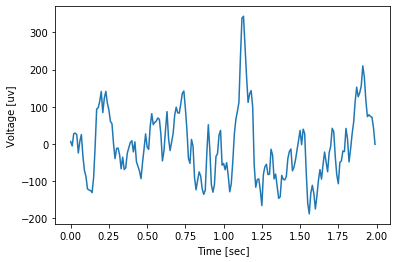

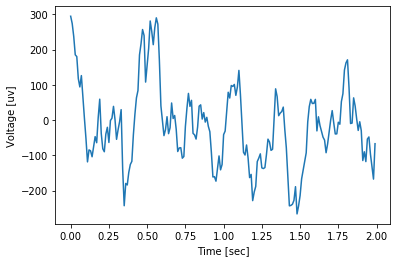

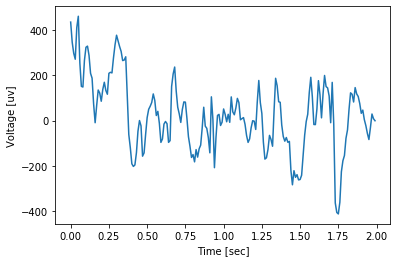

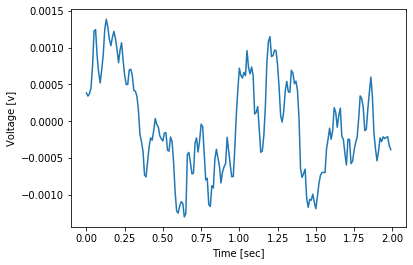

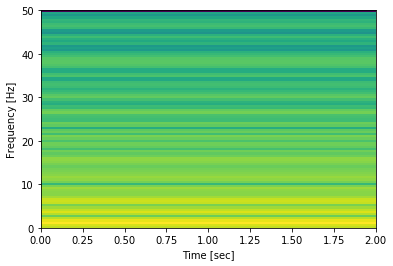

In [17]:
# 根据与DBA得分最高的数据画出原始的数据
import os
BDP_val_prediction_path = "./data/BDP_val_prediction.pkl"
BDP_val_prediction = np.load(BDP_val_prediction_path, allow_pickle =True)
def makedir(path):
    if os.path.exists(path) is not True:
        os.makedirs(path)
        print("文件创建成功！")
print(top_wave_cluster)
for cluster_id, feature_ids in top_wave_cluster.items():
    print("Cluster ID{}".format(cluster_id))
    path_negative = "./result/Cluster{}/negative".format(cluster_id)
    path_positive = "./result/Cluster{}/positive".format(cluster_id)
    makedir(path_negative)
    makedir(path_positive)
    y_spectrogram = np.zeros(200)
    for f_id, _ in feature_ids:
        raw_path = fi_id_nfi_dict[f_id]["nfi_path"]
        label_ground_truth = BDP_val_prediction[f_id]["ground truth"]
        channel_no = feature_id_time_spatial[f_id]["spatial"]
        raw_data_channel = np.load(raw_path)[channel_no]
        x = np.arange(0, 2, 0.01)
        y_spectrogram += raw_data_channel
        plt.plot(x, raw_data_channel*1e6)
        plt.xlabel("Time [sec]")
        plt.ylabel("Voltage [uv]")
        save_path = os.path.join(path_negative, f_id+".pdf") if label_ground_truth == 0 else os.path.join(path_positive, f_id+".pdf")
        plt.savefig(save_path)
        plt.show()
    spectrogram_draw(y_spectrogram)
        

##  4.从cluster的数据中进行选择部分的feature的数据进行聚类

In [15]:
wave_cluster_id_feature_data_path = "./processing/wave_clusters_id_feature_data.pkl"
wave_cluster_id_feature_data = np.load(wave_cluster_id_feature_data_path, allow_pickle = True)
top_wave_cluster_heatmap = get_top_score_series(wave_cluster_id_feature_data, DBA_wave, top_n = 5)
print(top_wave_cluster_heatmap)







{2: [('a4e5e525-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8910306576809078), ('a59dcf02-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8892551471992869), ('a4e5e54c-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8823149079817462), ('a5c1d710-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8773211121335235), ('a5531e03-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8724919222102387)], 3: [('b12e684a-2555-11ea-9699-e0d55e6ff654-0.npy', 0.9605567894522832), ('a4e5e61e-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.957780533268247), ('a5770d6e-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.9570263447828543), ('b12e666a-2555-11ea-9699-e0d55e6ff654-0.npy', 0.9547789033410146), ('b12e66ba-2555-11ea-9699-e0d55e6ff654-0.npy', 0.9540476260923931)], 4: [('a59dcfe2-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8598858375482412), ('a52f397c-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8593125215331449), ('a5531e64-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8473611818653434), ('a5c1d758-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8422742037380102), ('a5531f36-fa3a-11e9-a8f2-e0

In [16]:
save_path = "./processing/top_cluater_wave__fid_data.pkl"
with open(save_path, 'wb') as f:
    pickle.dump(top_wave_cluster_heatmap, f)
    print("top cluster_id 写入成功")


top cluster_id 写入成功


### 3.1 频谱图功能测试

In [ ]:
def specgram_draw(data):
    duration_time = 2
    dt = 0.01
    x = np.arange(0.0, duration_time, dt)
    plt.plot(x, data)
    NFFT = 200
    Fs = 100
    plt.show()
    Pxx, freqs, bins, im = plt.specgram(data, NFFT=NFFT, Fs=Fs, noverlap=0)
    # The `specgram` method returns 4 objects. They are:
    # - Pxx: the periodogram
    # - freqs: the frequency vector
    # - bins: the centers of the time bins
    # - im: the matplotlib.image.AxesImage instance representing the data in the plot
    plt.xlabel("Time [sec]")
    plt.ylabel("Frequency [Hz]")
    plt.show()
t = np.arange(0, 2, 0.01)
s1 = np.sin(2 * np.pi * 20 * t)
s2 = 2 * np.sin(2 * np.pi * 30 * t)
y  = s1+s2+10 * np.sin(2 * np.pi * 45 * t)
specgram_draw(y)
print(len(y))